In [86]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import os
from tqdm.notebook import tqdm

In [87]:
#!pip install matplotlib

In [88]:
path = "./"

calendar = pd.read_csv(os.path.join(path, "calendar.csv"))
selling_prices = pd.read_csv(os.path.join(path, "sell_prices.csv"))
sample_submission = pd.read_csv(os.path.join(path, "sample_submission.csv"))
sales = pd.read_csv(os.path.join(path, "sales_train_validation.csv"))

In [89]:
!ls

20200508(1).ipynb		sample_submission.csv.zip
20200508(2).ipynb		sell_prices.csv
Untitled1.ipynb			sell_prices.csv.zip
calendar.csv			submission.csv
docker_command.txt		test_from_1858_till_1914.ipynb
model.txt			test_from_1914_till_1969.ipynb
sales.csv			train.bin
sales_train_validation.csv	url.txt
sales_train_validation.csv.zip	valid_data_label.npz
sample_submission.csv


In [90]:
#!apt-get install unzip

In [91]:
#!unzip sales_train_validation.csv.zip

In [92]:
#!unzip sample_submission.csv.zip

In [93]:
#!unzip sell_prices.csv.zip

In [94]:
from sklearn.preprocessing import OrdinalEncoder

def prep_calendar(df):
    df = df.drop(["date", "weekday", "event_name_2", "event_type_2"], axis=1)
    df = df.assign(d = df.d.str[2:].astype(int))
    to_ordinal = ["event_name_1", "event_type_1"] 
    df[to_ordinal] = df[to_ordinal].fillna("1")
    df[to_ordinal] = OrdinalEncoder(dtype="int").fit_transform(df[to_ordinal]) + 1
    to_int8 = ["wday", "month", "snap_CA", "snap_TX", "snap_WI"] + to_ordinal
    df[to_int8] = df[to_int8].astype("int8")
    return df

calendar = prep_calendar(calendar)
calendar.head()

,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI
0,11101,1,1,2011,1,1,1,0,0,0
1,11101,2,1,2011,2,1,1,0,0,0
2,11101,3,1,2011,3,1,1,0,0,0
3,11101,4,2,2011,4,1,1,1,1,0
4,11101,5,2,2011,5,1,1,1,0,1


In [95]:
def prep_selling_prices(df):
    gr = df.groupby(["store_id", "item_id"])["sell_price"]
    df["sell_price_rel_diff"] = gr.pct_change()
    df["sell_price_cumrel"] = (gr.shift(0) - gr.cummin()) / (1 + gr.cummax() - gr.cummin())
    df["sell_price_roll_sd7"] = gr.transform(lambda x: x.rolling(7).std())
    to_float32 = ["sell_price", "sell_price_rel_diff", "sell_price_cumrel", "sell_price_roll_sd7"]
    df[to_float32] = df[to_float32].astype("float32")
         
    return df

selling_prices = prep_selling_prices(selling_prices)
selling_prices.head(14)

,store_id,item_id,wm_yr_wk,sell_price,sell_price_rel_diff,sell_price_cumrel,sell_price_roll_sd7
0,CA_1,HOBBIES_1_001,11325,9.58,NaN,0.0,NaN
1,CA_1,HOBBIES_1_001,11326,9.58,0.000000,0.0,NaN
2,CA_1,HOBBIES_1_001,11327,8.26,-0.137787,0.0,NaN
3,CA_1,HOBBIES_1_001,11328,8.26,0.000000,0.0,NaN
4,CA_1,HOBBIES_1_001,11329,8.26,0.000000,0.0,NaN
5,CA_1,HOBBIES_1_001,11330,8.26,0.000000,0.0,NaN
6,CA_1,HOBBIES_1_001,11331,8.26,0.000000,0.0,6.440940e-01
7,CA_1,HOBBIES_1_001,11332,8.26,0.000000,0.0,4.989131e-01
8,CA_1,HOBBIES_1_001,11333,8.26,0.000000,0.0,1.360284e-08
9,CA_1,HOBBIES_1_001,11334,8.26,0.000000,0.0,1.360284e-08


In [96]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [97]:
sales.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
30485,FOODS_3_823_WI_3_validation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,2,0,0,0,0,0,1,0,0,1
30486,FOODS_3_824_WI_3_validation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
30487,FOODS_3_825_WI_3_validation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,2,1,0,2,0,1,0,0,1,0
30488,FOODS_3_826_WI_3_validation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,1,0,0,1,0,3,1,3
30489,FOODS_3_827_WI_3_validation,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
len(sales.id.unique())

30490

In [99]:
# all ids have "validation"
sales.id.str.contains("validation").sum()

30490

In [100]:
def reshape_sales(df, drop_d = None):
    if drop_d is not None:
        df = df.drop(["d_" + str(i+1) for i in range(drop_d-1)], axis=1)
    df = df.assign(id=df.id.str.replace("_validation", ""))
    df = df.reindex(columns=df.columns.tolist() + ["d_" + str(1913 + i + 1) for i in range(2 * 28)])
    df = df.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                 var_name='d', value_name='demand')
    df = df.assign(d=df.d.str[2:].astype("int64"))

    return df

sales = reshape_sales(sales, 1000)
sales.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand
29575295,FOODS_3_823_WI_3,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1969,NaN
29575296,FOODS_3_824_WI_3,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1969,NaN
29575297,FOODS_3_825_WI_3,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1969,NaN
29575298,FOODS_3_826_WI_3,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1969,NaN
29575299,FOODS_3_827_WI_3,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,1969,NaN


In [101]:
sales.d.unique()

array([1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010,
       1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021,
       1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032,
       1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043,
       1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054,
       1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065,
       1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076,
       1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087,
       1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098,
       1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109,
       1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120,
       1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131,
       1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142,
       1143, 1144, 1145, 1146, 1147, 1148, 1149, 11

In [102]:
ids = sales.columns[sales.columns.str.contains("id")]

In [103]:
ids = ids[:1]
print(ids)

Index(['id'], dtype='object')


In [104]:
'''
def prep_sales(df):
    df['lag_t28'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28))
    df['rolling_mean_t7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df['rolling_mean_t30'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    df['rolling_mean_t60'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(60).mean())
    df['rolling_mean_t90'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    df['rolling_mean_t180'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    df['rolling_std_t7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df['rolling_std_t30'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).std())
  
    to_float32 = ['lag_t28', 'rolling_mean_t7', 'rolling_mean_t30', 'rolling_mean_t60', 
                  'rolling_mean_t90', 'rolling_mean_t180', 'rolling_std_t7', 'rolling_std_t30']
    df[to_float32] = df[to_float32].astype("float32")
    
    # Remove rows with NAs except for submission rows. rolling_mean_t180 was selected as it produces most missings
    df = df[(df.d >= 1914) | (pd.notna(df.rolling_mean_t180))]
 
    return df

sales = prep_sales(sales)
'''

'\ndef prep_sales(df):\n    df[\'lag_t28\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28))\n    df[\'rolling_mean_t7\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(7).mean())\n    df[\'rolling_mean_t30\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(30).mean())\n    df[\'rolling_mean_t60\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(60).mean())\n    df[\'rolling_mean_t90\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(90).mean())\n    df[\'rolling_mean_t180\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(180).mean())\n    df[\'rolling_std_t7\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(7).std())\n    df[\'rolling_std_t30\'] = df.groupby([\'id\'])[\'demand\'].transform(lambda x: x.shift(28).rolling(30).std())\n  \n    to_float32 = [\'lag_t28\', \'rolling_mean_t7\', \'rolling_mean_t30

In [105]:
'''
def prep_sales_ex(df, subid=None):
    new_col_01 = 'lag_t28_' + subid
    new_col_02 = 'rolling_mean_t7_' + subid
    new_col_03 = 'rolling_mean_t30_' + subid
    new_col_04 = 'rolling_mean_t60_' + subid
    new_col_05 = 'rolling_mean_t90_' + subid
    new_col_06 = 'rolling_mean_t180_' + subid
    new_col_07 = 'rolling_std_t7_' + subid
    new_col_08 = 'rolling_std_t30_' + subid
    #new_col_09 = 'rolling_std_t60_' + subid
    new_col_09 = 'rolling_mean_t14_' + subid
    df[new_col_01] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28))
    df[new_col_02] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df[new_col_03] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    df[new_col_04] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(60).mean())
    df[new_col_05] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    df[new_col_06] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    df[new_col_07] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df[new_col_08] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(30).std())
    #df[new_col_09] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(60).std())
    df[new_col_09] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*2).std())
  
    to_float32 = [new_col_01, new_col_02, new_col_03, new_col_04, new_col_05, new_col_06, new_col_07, new_col_08, new_col_09]
    df[to_float32] = df[to_float32].astype("float32")
    
    # Remove rows with NAs except for submission rows. rolling_mean_t180 was selected as it produces most missings
    df = df[(df.d >= 1914) | (pd.notna(df[new_col_06]))]
 
    return df

for subid in ids:
    sales = prep_sales_ex(sales, subid=subid)
'''

'\ndef prep_sales_ex(df, subid=None):\n    new_col_01 = \'lag_t28_\' + subid\n    new_col_02 = \'rolling_mean_t7_\' + subid\n    new_col_03 = \'rolling_mean_t30_\' + subid\n    new_col_04 = \'rolling_mean_t60_\' + subid\n    new_col_05 = \'rolling_mean_t90_\' + subid\n    new_col_06 = \'rolling_mean_t180_\' + subid\n    new_col_07 = \'rolling_std_t7_\' + subid\n    new_col_08 = \'rolling_std_t30_\' + subid\n    #new_col_09 = \'rolling_std_t60_\' + subid\n    new_col_09 = \'rolling_mean_t14_\' + subid\n    df[new_col_01] = df.groupby([subid])[\'demand\'].transform(lambda x: x.shift(28))\n    df[new_col_02] = df.groupby([subid])[\'demand\'].transform(lambda x: x.shift(28).rolling(7).mean())\n    df[new_col_03] = df.groupby([subid])[\'demand\'].transform(lambda x: x.shift(28).rolling(30).mean())\n    df[new_col_04] = df.groupby([subid])[\'demand\'].transform(lambda x: x.shift(28).rolling(60).mean())\n    df[new_col_05] = df.groupby([subid])[\'demand\'].transform(lambda x: x.shift(28).roll

In [106]:
sales.d.unique()

array([1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010,
       1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021,
       1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032,
       1033, 1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043,
       1044, 1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054,
       1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065,
       1066, 1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076,
       1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087,
       1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098,
       1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109,
       1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120,
       1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 1129, 1130, 1131,
       1132, 1133, 1134, 1135, 1136, 1137, 1138, 1139, 1140, 1141, 1142,
       1143, 1144, 1145, 1146, 1147, 1148, 1149, 11

In [107]:
sales

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1000,0.0
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1000,0.0
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1000,0.0
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1000,1.0
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1000,1.0
...,...,...,...,...,...,...,...,...
29575295,FOODS_3_823_WI_3,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1969,NaN
29575296,FOODS_3_824_WI_3,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1969,NaN
29575297,FOODS_3_825_WI_3,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1969,NaN
29575298,FOODS_3_826_WI_3,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1969,NaN


In [108]:
d1914 = 1914 - 28*2

In [109]:
def prep_sales_ex(df, subid=None):
    #new_col_01 = 'lag_t7_' + subid
    #new_col_02 = 'lag_t14_' + subid
    #new_col_03 = 'lag_t21_' + subid
    new_col_04 = 'lag_t28_' + subid
    #new_col_05 = 'lag_t63_' + subid
    #new_col_06 = 'lag_t84_' + subid
    #new_col_07 = 'lag_t182_' + subid
    
    new_col_08 = 'rolling_mean_t7_' + subid
    new_col_09 = 'rolling_mean_t14_' + subid
    new_col_10 = 'rolling_mean_t21_' + subid
    new_col_11 = 'rolling_mean_t28_' + subid
    new_col_28 = 'rolling_mean_t35_' + subid
    new_col_29 = 'rolling_mean_t42_' + subid
    new_col_30 = 'rolling_mean_t49_' + subid
    new_col_31 = 'rolling_mean_t56_' + subid
    new_col_12 = 'rolling_mean_t63_' + subid
    new_col_13 = 'rolling_mean_t84_' + subid
    new_col_14 = 'rolling_mean_t182_' + subid
    new_col_27 = 'rolling_mean_t364_' + subid
    
    new_col_15 = 'rolling_std_t7_' + subid
    new_col_16 = 'rolling_std_t14_' + subid
    new_col_17 = 'rolling_std_t21_' + subid
    new_col_18 = 'rolling_std_t28_' + subid
    new_col_19 = 'rolling_std_t35_' + subid
    new_col_20 = 'rolling_std_t42_' + subid
    new_col_21 = 'rolling_std_t49_' + subid
    new_col_22 = 'rolling_std_t56_' + subid
    new_col_23 = 'rolling_std_t63_' + subid
    new_col_24 = 'rolling_std_t84_' + subid
    new_col_25 = 'rolling_std_t182_' + subid
    new_col_26 = 'rolling_std_t364_' + subid
    
    
    #df[new_col_01] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7))
    #df[new_col_02] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*2))
    #df[new_col_03] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*3))
    df[new_col_04] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*4))
    #df[new_col_05] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*9))
    #df[new_col_06] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*12))
    #df[new_col_07] = df.groupby([subid])['demand'].transform(lambda x: x.shift(7*26))
    
    df[new_col_08] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df[new_col_09] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*2).mean())
    df[new_col_10] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*3).mean())
    df[new_col_11] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*4).mean())
    df[new_col_28] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*5).mean())
    df[new_col_29] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*6).mean())
    df[new_col_30] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*7).mean())
    df[new_col_31] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*8).mean())
    df[new_col_12] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*9).mean())
    df[new_col_13] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*12).mean())
    df[new_col_14] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*26).mean())
    df[new_col_27] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*26*2).mean())

    df[new_col_15] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df[new_col_16] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*2).std())
    df[new_col_17] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*3).std())
    df[new_col_18] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*4).std())
    df[new_col_19] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*5).std())
    df[new_col_20] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*6).std())
    df[new_col_21] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*7).std())
    df[new_col_22] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*8).std())
    df[new_col_23] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*9).std())
    df[new_col_24] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*12).std())
    df[new_col_25] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*26).std())
    df[new_col_26] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*26*2).std())
  
    to_float32 = [#new_col_01, new_col_02, new_col_03, new_col_04, new_col_05, new_col_06, new_col_07,
                  new_col_04,
                  new_col_08, new_col_09, new_col_10, new_col_11, new_col_28, new_col_29, new_col_30, new_col_31,
                  new_col_12, new_col_13, new_col_14, new_col_27,
                  new_col_15, new_col_16, new_col_17, new_col_18, new_col_19, new_col_20, new_col_21, new_col_22, new_col_23, new_col_24, new_col_25, new_col_26]
    df[to_float32] = df[to_float32].astype("float32")
    
    # Remove rows with NAs except for submission rows. rolling_mean_t182 was selected as it produces most missings
    #df = df[(df.d >= 1914) | (pd.notna(df[new_col_26]))]
    df = df[(df.d >= d1914) | (pd.notna(df[new_col_26]))]
 
    return df

for subid in ids:
    sales = prep_sales_ex(sales, subid=subid)

In [110]:
sales.d.unique()

array([1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401,
       1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412,
       1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423,
       1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434,
       1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445,
       1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456,
       1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467,
       1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478,
       1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489,
       1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500,
       1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511,
       1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522,
       1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533,
       1534, 1535, 1536, 1537, 1538, 1539, 1540, 15

In [111]:
# d >= 1914 has no demand since this period is beyond the train data (1914 <= d < 1941: validation, d >= 1941: test)
sales[sales["demand"].isnull()]["d"].unique()

array([1914, 1915, 1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924,
       1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935,
       1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946,
       1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969])

In [68]:
def prep_sales_ex_loop(df, subid=None):
    new_col_01 = 'lag_t28_' + subid
    new_col_02 = 'rolling_mean_t7_' + subid
    new_col_03 = 'rolling_mean_t30_' + subid
    new_col_04 = 'rolling_mean_t60_' + subid
    new_col_05 = 'rolling_mean_t90_' + subid
    new_col_06 = 'rolling_mean_t180_' + subid
    new_col_07 = 'rolling_std_t7_' + subid
    new_col_08 = 'rolling_std_t30_' + subid
    df[new_col_01] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28))
    df[new_col_02] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df[new_col_03] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    df[new_col_04] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(60).mean())
    df[new_col_05] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(90).mean())
    df[new_col_06] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    df[new_col_07] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7).std())
    df[new_col_08] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(30).std())
  
    to_float32 = [new_col_01, new_col_02, new_col_03, new_col_04, new_col_05, new_col_06, new_col_07, new_col_08]
    df[to_float32] = df[to_float32].astype("float32")
    
    # Remove rows with NAs except for submission rows. rolling_mean_t180 was selected as it produces most missings
    df = df[(df.d >= 1914) | (pd.notna(df[new_col_06]))]
 
    return df

#for subid in ids:
#    sales = prep_sales_ex_loop(sales, subid=subid)

In [112]:
sales.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28_id,rolling_mean_t7_id,...,rolling_std_t21_id,rolling_std_t28_id,rolling_std_t35_id,rolling_std_t42_id,rolling_std_t49_id,rolling_std_t56_id,rolling_std_t63_id,rolling_std_t84_id,rolling_std_t182_id,rolling_std_t364_id
29575295,FOODS_3_823_WI_3,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29575296,FOODS_3_824_WI_3,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29575297,FOODS_3_825_WI_3,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29575298,FOODS_3_826_WI_3,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29575299,FOODS_3_827_WI_3,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
sales = sales.merge(calendar, how="left", on="d")
gc.collect()
sales.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28_id,rolling_mean_t7_id,...,rolling_std_t364_id,wm_yr_wk,wday,month,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI
17653705,FOODS_3_823_WI_3,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,NaN,11621,2,6,2016,18,5,0,0,0
17653706,FOODS_3_824_WI_3,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,NaN,11621,2,6,2016,18,5,0,0,0
17653707,FOODS_3_825_WI_3,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,NaN,11621,2,6,2016,18,5,0,0,0
17653708,FOODS_3_826_WI_3,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,NaN,11621,2,6,2016,18,5,0,0,0
17653709,FOODS_3_827_WI_3,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,NaN,11621,2,6,2016,18,5,0,0,0


In [114]:
sales = sales.merge(selling_prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])
sales.drop(["wm_yr_wk"], axis=1, inplace=True)
gc.collect()
del selling_prices
sales.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28_id,rolling_mean_t7_id,...,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_cumrel,sell_price_roll_sd7
17653705,FOODS_3_823_WI_3,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,2016,18,5,0,0,0,2.98,0.0,0.333333,1.753098e-08
17653706,FOODS_3_824_WI_3,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,2016,18,5,0,0,0,2.48,0.0,0.285714,0.000000e+00
17653707,FOODS_3_825_WI_3,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,2016,18,5,0,0,0,3.98,0.0,0.000000,2.404665e-08
17653708,FOODS_3_826_WI_3,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,2016,18,5,0,0,0,1.28,0.0,0.000000,0.000000e+00
17653709,FOODS_3_827_WI_3,FOODS_3_827,FOODS_3,FOODS,WI_3,WI,1969,NaN,NaN,NaN,...,2016,18,5,0,0,0,1.00,0.0,0.000000,0.000000e+00


In [115]:
#for i, v in tqdm(enumerate(["item_id", "dept_id", "store_id", "cat_id", "state_id"])):
for i, v in enumerate(["item_id", "dept_id", "store_id", "cat_id", "state_id"]):
    sales[v] = OrdinalEncoder(dtype="int").fit_transform(sales[[v]]).astype("int16") + 1
gc.collect()

22

In [116]:
sales.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28_id,rolling_mean_t7_id,...,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_cumrel,sell_price_roll_sd7
17653705,FOODS_3_823_WI_3,1433,3,1,10,3,1969,NaN,NaN,NaN,...,2016,18,5,0,0,0,2.98,0.0,0.333333,1.753098e-08
17653706,FOODS_3_824_WI_3,1434,3,1,10,3,1969,NaN,NaN,NaN,...,2016,18,5,0,0,0,2.48,0.0,0.285714,0.000000e+00
17653707,FOODS_3_825_WI_3,1435,3,1,10,3,1969,NaN,NaN,NaN,...,2016,18,5,0,0,0,3.98,0.0,0.000000,2.404665e-08
17653708,FOODS_3_826_WI_3,1436,3,1,10,3,1969,NaN,NaN,NaN,...,2016,18,5,0,0,0,1.28,0.0,0.000000,0.000000e+00
17653709,FOODS_3_827_WI_3,1437,3,1,10,3,1969,NaN,NaN,NaN,...,2016,18,5,0,0,0,1.00,0.0,0.000000,0.000000e+00


In [ ]:
#sales.to_csv("sales.csv")

In [ ]:
# Start from here from next time
#sales = pd.read_csv("sales.csv")

In [117]:
#base_features = ["lag_t28", "rolling_mean_t7", "rolling_mean_t30", "rolling_mean_t60", 
#                 "rolling_mean_t90", "rolling_mean_t180", "rolling_std_t7", "rolling_std_t30", "rolling_mean_t14"]
base_features = [#'lag_t7_', 'lag_t14_', 'lag_t21_', 'lag_t28_', 'lag_t63_', 'lag_t84_', 'lag_t182_', 
                 'lag_t28_',
                 'rolling_mean_t7_', 'rolling_mean_t14_', 'rolling_mean_t21_', 
                 'rolling_mean_t28_', 'rolling_mean_t35_', 'rolling_mean_t42_', 'rolling_mean_t49_', 'rolling_mean_t56_',
                 'rolling_mean_t63_', 'rolling_mean_t84_', 'rolling_mean_t182_', 'rolling_mean_t364_',
                 'rolling_std_t7_', 'rolling_std_t14_', 'rolling_std_t21_', 
                 'rolling_std_t28_', 'rolling_std_t35_', 'rolling_std_t42_', 'rolling_std_t49_', 'rolling_std_t56_',
                 'rolling_std_t63_', 'rolling_std_t84_', 'rolling_std_t182_', 'rolling_std_t364_']


extended_features = []
for subid in ids:
    tmp = [v+subid for v in base_features]
    extended_features.extend(tmp)
#extended_features = [v+"_state_id" for v in base_features]

In [118]:
extended_features

['lag_t28_id',
 'rolling_mean_t7_id',
 'rolling_mean_t14_id',
 'rolling_mean_t21_id',
 'rolling_mean_t28_id',
 'rolling_mean_t35_id',
 'rolling_mean_t42_id',
 'rolling_mean_t49_id',
 'rolling_mean_t56_id',
 'rolling_mean_t63_id',
 'rolling_mean_t84_id',
 'rolling_mean_t182_id',
 'rolling_mean_t364_id',
 'rolling_std_t7_id',
 'rolling_std_t14_id',
 'rolling_std_t21_id',
 'rolling_std_t28_id',
 'rolling_std_t35_id',
 'rolling_std_t42_id',
 'rolling_std_t49_id',
 'rolling_std_t56_id',
 'rolling_std_t63_id',
 'rolling_std_t84_id',
 'rolling_std_t182_id',
 'rolling_std_t364_id']

In [119]:
# Covariables used
x = ["wday", "month", "year", 
     "event_name_1", "event_type_1",
     "snap_CA", "snap_TX", "snap_WI",
     "sell_price", "sell_price_rel_diff", "sell_price_cumrel", "sell_price_roll_sd7",
     "item_id", "dept_id", "cat_id", "store_id", "state_id"]

In [120]:
#x.extend(base_features)

In [121]:
x.extend(extended_features)

In [122]:
len(x)

42

In [123]:
x

['wday',
 'month',
 'year',
 'event_name_1',
 'event_type_1',
 'snap_CA',
 'snap_TX',
 'snap_WI',
 'sell_price',
 'sell_price_rel_diff',
 'sell_price_cumrel',
 'sell_price_roll_sd7',
 'item_id',
 'dept_id',
 'cat_id',
 'store_id',
 'state_id',
 'lag_t28_id',
 'rolling_mean_t7_id',
 'rolling_mean_t14_id',
 'rolling_mean_t21_id',
 'rolling_mean_t28_id',
 'rolling_mean_t35_id',
 'rolling_mean_t42_id',
 'rolling_mean_t49_id',
 'rolling_mean_t56_id',
 'rolling_mean_t63_id',
 'rolling_mean_t84_id',
 'rolling_mean_t182_id',
 'rolling_mean_t364_id',
 'rolling_std_t7_id',
 'rolling_std_t14_id',
 'rolling_std_t21_id',
 'rolling_std_t28_id',
 'rolling_std_t35_id',
 'rolling_std_t42_id',
 'rolling_std_t49_id',
 'rolling_std_t56_id',
 'rolling_std_t63_id',
 'rolling_std_t84_id',
 'rolling_std_t182_id',
 'rolling_std_t364_id']

In [124]:
d1942 = d1914 + 28
d1970 = d1914 + 28*2
print(d1914, d1942, d1970)

1858 1886 1914


In [125]:
len(sales[(sales.d >= d1914)&(sales.d < d1970)].d.unique())

56

In [126]:
#test = sales[sales.d >= d1914]
test = sales[(sales.d >= d1914)&(sales.d < d1970)]
test.tail()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28_id,rolling_mean_t7_id,...,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_cumrel,sell_price_roll_sd7
15946265,FOODS_3_823_WI_3,1433,3,1,10,3,1913,1.0,0.0,0.000000,...,2016,1,1,0,0,0,2.98,0.0,0.333333,1.753098e-08
15946266,FOODS_3_824_WI_3,1434,3,1,10,3,1913,0.0,0.0,0.000000,...,2016,1,1,0,0,0,2.48,0.0,0.285714,2.565708e-01
15946267,FOODS_3_825_WI_3,1435,3,1,10,3,1913,0.0,1.0,0.714286,...,2016,1,1,0,0,0,3.98,0.0,0.000000,2.404665e-08
15946268,FOODS_3_826_WI_3,1436,3,1,10,3,1913,3.0,4.0,1.571429,...,2016,1,1,0,0,0,1.28,0.0,0.000000,0.000000e+00
15946269,FOODS_3_827_WI_3,1437,3,1,10,3,1913,0.0,5.0,2.428571,...,2016,1,1,0,0,0,1.00,0.0,0.000000,0.000000e+00


In [127]:
test.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28_id,rolling_mean_t7_id,...,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_cumrel,sell_price_roll_sd7
14238830,HOBBIES_1_001_CA_1,1438,4,2,1,1,1858,0.0,1.0,0.714286,...,2016,1,1,0,0,0,8.26,0.0,0.000000,1.360284e-08
14238831,HOBBIES_1_002_CA_1,1439,4,2,1,1,1858,0.0,1.0,0.285714,...,2016,1,1,0,0,0,3.97,0.0,0.000000,0.000000e+00
14238832,HOBBIES_1_003_CA_1,1440,4,2,1,1,1858,0.0,0.0,0.142857,...,2016,1,1,0,0,0,2.97,0.0,0.000000,0.000000e+00
14238833,HOBBIES_1_004_CA_1,1441,4,2,1,1,1858,0.0,1.0,2.714286,...,2016,1,1,0,0,0,4.64,0.0,0.230769,1.226143e-08
14238834,HOBBIES_1_005_CA_1,1442,4,2,1,1,1858,1.0,0.0,0.857143,...,2016,1,1,0,0,0,2.88,0.0,0.250000,1.430725e-08


In [128]:
test = test.assign(id=test.id + "_" + np.where(test.d < d1942, "validation", "evaluation"), 
                   F="F" + (test.d - d1914+1 - 28 * (test.d >= d1942)).astype("str"))
#test = test.assign(id=test.id + "_" + np.where(test.d <= 1941, "validation", "evaluation"), 
#                   F="F" + (test.d - 1913 - 28 * (test.d > 1941)).astype("str"))

In [129]:
test.F.unique()

array(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20',
       'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28'],
      dtype=object)

In [130]:
test.d.unique()

array([1858, 1859, 1860, 1861, 1862, 1863, 1864, 1865, 1866, 1867, 1868,
       1869, 1870, 1871, 1872, 1873, 1874, 1875, 1876, 1877, 1878, 1879,
       1880, 1881, 1882, 1883, 1884, 1885, 1886, 1887, 1888, 1889, 1890,
       1891, 1892, 1893, 1894, 1895, 1896, 1897, 1898, 1899, 1900, 1901,
       1902, 1903, 1904, 1905, 1906, 1907, 1908, 1909, 1910, 1911, 1912,
       1913])

In [131]:
# Reduce sales
sales = sales[sales.d < d1914]
gc.collect()
sales.d.unique()

array([1391, 1392, 1393, 1394, 1395, 1396, 1397, 1398, 1399, 1400, 1401,
       1402, 1403, 1404, 1405, 1406, 1407, 1408, 1409, 1410, 1411, 1412,
       1413, 1414, 1415, 1416, 1417, 1418, 1419, 1420, 1421, 1422, 1423,
       1424, 1425, 1426, 1427, 1428, 1429, 1430, 1431, 1432, 1433, 1434,
       1435, 1436, 1437, 1438, 1439, 1440, 1441, 1442, 1443, 1444, 1445,
       1446, 1447, 1448, 1449, 1450, 1451, 1452, 1453, 1454, 1455, 1456,
       1457, 1458, 1459, 1460, 1461, 1462, 1463, 1464, 1465, 1466, 1467,
       1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478,
       1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489,
       1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500,
       1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511,
       1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522,
       1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533,
       1534, 1535, 1536, 1537, 1538, 1539, 1540, 15

In [132]:
test

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28_id,rolling_mean_t7_id,...,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_cumrel,sell_price_roll_sd7,F
14238830,HOBBIES_1_001_CA_1_validation,1438,4,2,1,1,1858,0.0,1.0,0.714286,...,1,1,0,0,0,8.26,0.0,0.000000,1.360284e-08,F1
14238831,HOBBIES_1_002_CA_1_validation,1439,4,2,1,1,1858,0.0,1.0,0.285714,...,1,1,0,0,0,3.97,0.0,0.000000,0.000000e+00,F1
14238832,HOBBIES_1_003_CA_1_validation,1440,4,2,1,1,1858,0.0,0.0,0.142857,...,1,1,0,0,0,2.97,0.0,0.000000,0.000000e+00,F1
14238833,HOBBIES_1_004_CA_1_validation,1441,4,2,1,1,1858,0.0,1.0,2.714286,...,1,1,0,0,0,4.64,0.0,0.230769,1.226143e-08,F1
14238834,HOBBIES_1_005_CA_1_validation,1442,4,2,1,1,1858,1.0,0.0,0.857143,...,1,1,0,0,0,2.88,0.0,0.250000,1.430725e-08,F1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15946265,FOODS_3_823_WI_3_evaluation,1433,3,1,10,3,1913,1.0,0.0,0.000000,...,1,1,0,0,0,2.98,0.0,0.333333,1.753098e-08,F28
15946266,FOODS_3_824_WI_3_evaluation,1434,3,1,10,3,1913,0.0,0.0,0.000000,...,1,1,0,0,0,2.48,0.0,0.285714,2.565708e-01,F28
15946267,FOODS_3_825_WI_3_evaluation,1435,3,1,10,3,1913,0.0,1.0,0.714286,...,1,1,0,0,0,3.98,0.0,0.000000,2.404665e-08,F28
15946268,FOODS_3_826_WI_3_evaluation,1436,3,1,10,3,1913,3.0,4.0,1.571429,...,1,1,0,0,0,1.28,0.0,0.000000,0.000000e+00,F28


In [133]:
# "F1" is assined to both d=1914 and 1942, for example
test[test.F == "F1"].d.unique()

array([1858, 1886])

In [134]:
# "F28" is assined to both d=1941 and 1969, for example
test[test.F == "F28"].d.unique()

array([1885, 1913])

In [135]:
import lightgbm as lgb

In [136]:
# One month of validation data
#flag = sales.d >= 1914 - 28
flag = sales.d >= d1914 - 28
valid = lgb.Dataset(sales[flag][x], label = sales[["demand"]][flag])
#np.savez('valid_data_label', data=sales[flag][x], label=sales[["demand"]][flag])
gc.collect()

# Rest is used for training
sales = sales[~flag].drop(["d", "id"], axis=1)
del flag
gc.collect()
sales = lgb.Dataset(sales[x], label = sales[["demand"]])

# Trick to avoid memory spike when LightGBM converts everything to float32:
#   See https://www.kaggle.com/c/talkingdata-adtracking-fraud-detection/discussion/53773
#sales.save_binary('train.bin')
#sales = lgb.Dataset('train.bin')

In [137]:
params = {
    'metric': 'rmse',
    'objective': 'poisson',
    'seed': 20,
    'learning_rate': 0.08,
    'lambda': 0.1,
    'num_leaves': 63,
    'bagging_fraction': 0.7,
    'bagging_freq': 1, 
    'colsample_bytree': 0.7
}

fit = lgb.train(params, 
                sales, 
                num_boost_round = 2100, 
                valid_sets = [valid], 
                early_stopping_rounds = 400,
                verbose_eval = 100)

Training until validation scores don't improve for 400 rounds
[100]	valid_0's rmse: 2.40099
[200]	valid_0's rmse: 2.38376
[300]	valid_0's rmse: 2.38902
[400]	valid_0's rmse: 2.39265
[500]	valid_0's rmse: 2.39239
[600]	valid_0's rmse: 2.39311
Early stopping, best iteration is:
[238]	valid_0's rmse: 2.38371


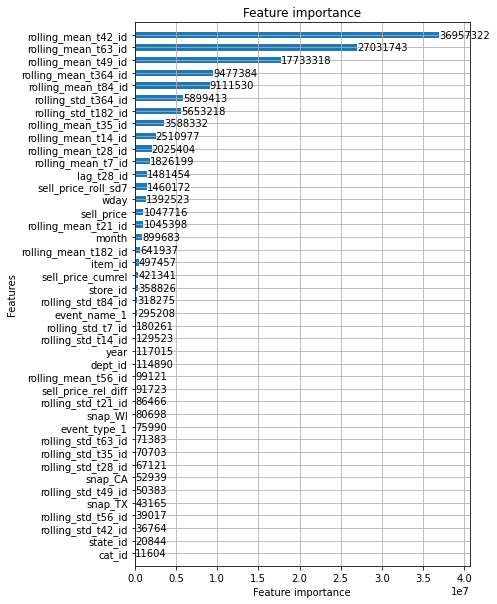

In [138]:
lgb.plot_importance(fit, importance_type="gain", precision=0, height=0.5, figsize=(6, 10));

In [ ]:
# Validation & Visualization
'''

print('Saving model...')
# save model to file
fit.save_model('model.txt')

print('Loading model to predict...')
# load model to predict
fit = lgb.Booster(model_file='model.txt')


npz = np.load("./valid_data_label.npz")
valid_data = npz["data"]
#valid_data

valid_label = npz["label"]
#valid_label

pred = fit.predict(valid_data)

#plt.figure(14, 6)
plt.plot(range(28), valid_label[:28], color='blue')
plt.plot(range(28), pred[:28], color='red');
'''

In [139]:
pred = fit.predict(test[x])
pred

array([0.71185893, 0.32210602, 0.3720152 , ..., 0.96489308, 1.38941858,
       2.34766933])

In [140]:
pred.shape

(1707440,)

In [141]:
test.shape

(1707440, 46)

In [142]:
# The dark magic -> credits: https://www.kaggle.com/kyakovlev/m5-dark-magic
pred_calibrated = pred / pred[test["id"].str.endswith("validation")].mean() * 1.447147
pred_calibrated.shape

(1707440,)

In [143]:
#test["demand"] = pred
test["demand"] = pred_calibrated
test.shape

(1707440, 46)

In [144]:
test.F.unique()

array(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'F16', 'F17', 'F18', 'F19', 'F20',
       'F21', 'F22', 'F23', 'F24', 'F25', 'F26', 'F27', 'F28'],
      dtype=object)

In [148]:
test[test.F=="F1"]

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28_id,rolling_mean_t7_id,...,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff,sell_price_cumrel,sell_price_roll_sd7,F
14238830,HOBBIES_1_001_CA_1_validation,1438,4,2,1,1,1858,0.769656,1.0,0.714286,...,1,1,0,0,0,8.26,0.0,0.000000,1.360284e-08,F1
14238831,HOBBIES_1_002_CA_1_validation,1439,4,2,1,1,1858,0.348258,1.0,0.285714,...,1,1,0,0,0,3.97,0.0,0.000000,0.000000e+00,F1
14238832,HOBBIES_1_003_CA_1_validation,1440,4,2,1,1,1858,0.402220,0.0,0.142857,...,1,1,0,0,0,2.97,0.0,0.000000,0.000000e+00,F1
14238833,HOBBIES_1_004_CA_1_validation,1441,4,2,1,1,1858,2.220913,1.0,2.714286,...,1,1,0,0,0,4.64,0.0,0.230769,1.226143e-08,F1
14238834,HOBBIES_1_005_CA_1_validation,1442,4,2,1,1,1858,0.970662,0.0,0.857143,...,1,1,0,0,0,2.88,0.0,0.250000,1.430725e-08,F1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15123035,FOODS_3_823_WI_3_evaluation,1433,3,1,10,3,1886,0.650742,0.0,0.285714,...,1,1,0,0,0,2.98,0.0,0.333333,5.345225e-02,F1
15123036,FOODS_3_824_WI_3_evaluation,1434,3,1,10,3,1886,0.098619,0.0,0.000000,...,1,1,0,0,0,2.00,0.0,0.000000,1.178040e-08,F1
15123037,FOODS_3_825_WI_3_evaluation,1435,3,1,10,3,1886,0.645411,1.0,0.571429,...,1,1,0,0,0,3.98,0.0,0.000000,2.404665e-08,F1
15123038,FOODS_3_826_WI_3_evaluation,1436,3,1,10,3,1886,0.949107,2.0,0.285714,...,1,1,0,0,0,1.28,0.0,0.000000,0.000000e+00,F1


In [145]:
submission = test.pivot(index="id", columns="F", values="demand").reset_index()[sample_submission.columns]
submission.head()

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.653557,0.561516,0.608374,0.566430,0.645471,0.940272,0.837487,0.620539,0.583237,...,0.771319,1.040714,1.059221,0.712158,0.752389,0.823489,0.734143,0.862615,1.131139,1.027429
1,FOODS_1_001_CA_1_validation,0.620999,0.681551,0.619953,0.726912,0.771154,1.138921,0.982252,0.886622,0.741979,...,0.762258,1.093881,0.978698,0.690473,0.690675,0.645115,0.612663,0.688560,0.874511,0.732092
2,FOODS_1_001_CA_2_evaluation,0.949010,0.895963,0.970374,1.018691,1.150661,1.854679,1.537810,1.257668,1.061756,...,1.166420,1.359977,1.519700,1.049374,0.884773,0.872423,0.862215,0.933473,1.395449,1.300438
3,FOODS_1_001_CA_2_validation,1.037776,0.966340,0.896535,0.901768,0.934778,1.536802,1.324986,1.040950,0.965922,...,1.132889,1.684738,1.697380,1.335046,1.211804,1.141232,1.089752,1.219866,1.486571,1.195740
4,FOODS_1_001_CA_3_evaluation,1.437793,1.571648,1.476015,1.382468,1.649191,1.650609,1.478475,1.142867,1.126621,...,1.067576,1.299363,1.484600,1.212646,1.097600,1.166247,1.162939,1.252282,2.016112,1.574956


In [146]:
submission.to_csv("submission.csv", index=False)

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200505(2)" # df[new_col_09] = df.groupby([subid])['demand'].transform(lambda x: x.shift(28).rolling(7*2).std()) added

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200505(3)" 
''' with base_features = ['lag_t7_', 'lag_t14_', 'lag_t21_', 'lag_t28_', 'lag_t63_', 'lag_t84_', 'lag_t182_', 
                          'rolling_mean_t7_', 'rolling_mean_t14_', 'rolling_mean_t21_', 'rolling_mean_t28_', 'rolling_mean_t63_', 'rolling_mean_t84_', 'rolling_mean_t182_',
                          'rolling_std_t7_', 'rolling_std_t14_', 'rolling_std_t21_', 'rolling_std_t28_', 'rolling_std_t63_', 'rolling_std_t84_', 'rolling_std_t182_']
'''

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200506(1) remove from lag7 from lag182 but lag28"  # 0.54475

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200506(2) increase num of leaves from 63 to 63*2" # 0.54823

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200506(3) reduce learning rate from 0.08 to 0.04 and increase num boost round from 2100 to 4200" # 0.54979

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200507(1) add std35, std42, std49 and std56" # 0.54771

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200507(2) add std364" # 0.55362

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200507(3) add mean364" # 0.56688

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200508(1) add mean35" # 0.56041

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200508(2) add mean42, mean49 and mean56" # 0.55153

In [ ]:
#!kaggle competitions submit -c m5-forecasting-accuracy -f submission.csv -m "20200517(1) test period: from d1886 to d1913" # 